<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/UV_Stellar_Catalog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pysynphot --quiet
!pip install git+https://github.com/rlwastro/mastcasjobs@master --quiet
!pip install git+https://github.com/astrofrog/sedfitter@master --quiet

     |████████████████████████████████| 10.8 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


In [2]:
import pysynphot as S

/usr/local/lib/python3.7/dist-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/usr/local/lib/python3.7/dist-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [3]:
!export PYSYN_CDBS=/my/local/dir/trds/

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import gaussian_fwhm_to_sigma, gaussian_sigma_to_fwhm
from astropy.modeling import models, fitting
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy import wcs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import os
from time import perf_counter
import json
import requests
import pysynphot as S
import sedfitter as sed

import mastcasjobs

# get the WSID and password if not already defined
if not os.environ.get('CASJOBS_USERID'):
    os.environ['CASJOBS_USERID'] = "avinashck90"
if not os.environ.get('CASJOBS_PW'):
    os.environ['CASJOBS_PW'] = "INSIST369"

sb.set_style('darkgrid')
matplotlib.rcParams['font.size']=12
matplotlib.rcParams['figure.figsize']=(10,10)


# **CasJobs**

In [6]:
def mastQuery(request, json_return=False):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object
    
    Returns the text response or (if json_return=True) the json response
    """
    
    url = "https://mast.stsci.edu/api/v0/invoke"

    # Encoding the request as a json string
    requestString = json.dumps(request)
    
    # make the query
    r = requests.post(url, data=dict(request=requestString))
    
    # raise exception on error
    r.raise_for_status()
    
    if json_return:
        return r.json()
    else:
        return r.text


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position"""

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    resolvedObject = mastQuery(resolverRequest, json_return=True)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)

In [7]:
class casjobs():
    """PSF Generator using Source catalog or CasJobs GALEX Catalog

    Parameters
    ----------
    name (string) : Catalog name or coordinates of the source

    df   (pd.DataFrame ): Pandas dataframe with source catalog

    cols (dict) : dict object with column name conversions for ra,dec,mag_nuv. Eg {'RA': 'ra','Dec' : 'dec', 'ABmag' : 'mag_nuv'}

        'ra' (degrees)

        'dec' (degrees)

        'mag_nuv' (ABmag)

    pixel_scale (float) : pixel scale of detector in the unit of arcseconds/pixels

    fwhm_in (float) : Full Width at Half Maximum of the Gaussian PSF

    n_pix_main (int) : Number of pixels along one axis in the detector. Total number of pixels in the detector is n_pix_main**2

    n_pix_sub (int) : Number of pixels along one axis in the path. Total number of pixels in the patch is n_pix_sub**2

    """
    def __init__(self,name = 'M 67',cols = None):   


        self.name = name
        self.ra,self.dec = resolve(name)
    
        self.jobs = mastcasjobs.MastCasJobs(context="PanSTARRS_DR2")
        self.query =   f"""select psc.objid,o.raStack,o.decStack,mag.gPSFMag, mag.gPSFMagErr,mag.rPSFMag, mag.rPSFMagErr,mag.iPSFMag, mag.iPSFMagErr,mag.zPSFMag,mag.zPSFMagErr, mag.yPSFMag,mag.yPSFMagErr,psc.ps_score
                          from fGetNearbyObjEq({self.ra}, {self.dec}, 10) f
                          join ObjectThin o on o.objid=f.objid
                          join HLSP_PS1_PSC.pointsource_scores psc on psc.objid=f.objid
                          join StackObjectThin mag on mag.objid=psc.objid
                          WHERE
                          mag.gPSFMag>-900 and 
                          mag.rPSFMag>-900 and 
                          mag.iPSFMag>-900 and 
                          mag.zPSFMag>-900 and 
                          mag.yPSFMag>-900 
                        """
        self.df = self.jobs.quick(self.query, task_name="python cone search").to_pandas() 
        if cols is not None:
          self.df = self.df.rename(columns=cols) 
    
    def show_field(self,figsize=(10,10)):
      """
      Function for creating a scatter plot of sources within the FoV
      
      Returns
      -------
      fig, ax
      """
        
      fig, ax = plt.subplots(1,1,figsize=figsize)
      ax.scatter(self.df['ra'],self.df['dec'],marker='.',color='black')
      ax.set_title(f" Requested Center : {self.name} \n  {len(self.df)} sources")
      ax.invert_xaxis()
      ax.set_xlabel('RA (Degrees)')
      ax.set_ylabel('Dec (Degrees)')
      return fig,ax
      
        

## **Query**

In [ ]:
obj = casjobs('M 67', cols = {'raStack':'ra','decStack':'dec'})

In [90]:
df_star = obj.df[obj.df['ps_score']>0.5]

In [91]:
df_star

,objid,ra,dec,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,iPSFMag,iPSFMagErr,zPSFMag,zPSFMagErr,yPSFMag,yPSFMagErr,ps_score
2,121971328494717854,132.849460,11.647811,14.8691,0.000533,14.3603,0.000274,14.2388,0.000320,14.2280,0.000519,14.1805,0.000877,0.997500
3,121981327802535449,132.780255,11.654201,22.4085,0.070046,21.0757,0.020825,19.8949,0.010747,19.3878,0.012878,19.2221,0.028750,0.967161
7,121981328054472261,132.805456,11.651512,20.5329,0.016547,20.0120,0.012918,19.6550,0.009876,19.5985,0.015401,19.5313,0.032895,0.973104
8,121981328218108430,132.821806,11.656615,21.3080,0.035670,20.0955,0.021422,18.9608,0.006396,18.4705,0.006572,18.1437,0.010728,0.987833
10,121981328277113751,132.827729,11.652668,21.9420,0.059630,20.6828,0.015879,19.3339,0.007499,18.8097,0.007518,18.4563,0.013550,0.969271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,122361328754558683,132.875457,11.973499,14.2652,0.000371,13.9342,0.000273,13.8645,0.000378,13.8345,0.000453,13.7998,0.000760,0.998333
1826,122361328754558683,132.875457,11.973499,14.2070,0.000346,13.9596,0.000281,13.8724,0.000384,13.8300,0.000452,13.8094,0.000760,0.998333
1827,122361328818090634,132.881819,11.966787,16.9712,0.001754,16.5763,0.001196,16.2176,0.002029,16.4170,0.002133,16.3843,0.003584,0.997500
1828,122371328134963003,132.813494,11.977090,14.2162,0.000410,13.8419,0.000236,13.6946,0.000315,13.6735,0.000408,13.6380,0.000744,0.994167


In [92]:
df_star['gPSFMag'].describe()

count    1058.000000
mean       19.314388
std         3.376858
min        12.298300
25%        16.248150
50%        19.823050
75%        21.971900
max        27.986600
Name: gPSFMag, dtype: float64

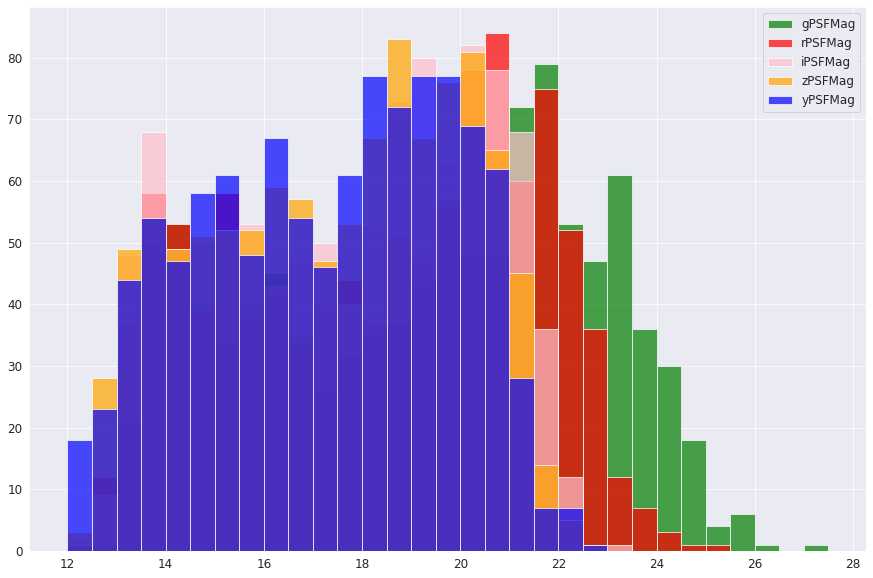

In [93]:
bin_min = 12
bin_max = 28
step  = 0.5
bins = np.arange(bin_min,bin_max, step)

plt.figure(figsize = (15,10))
plt.hist(df_star['gPSFMag'],bins=bins,alpha=0.7,color = 'green')
plt.hist(df_star['rPSFMag'],bins=bins,alpha=0.7,color = 'red')
plt.hist(df_star['iPSFMag'],bins=bins,alpha=0.7,color = 'pink')
plt.hist(df_star['zPSFMag'],bins=bins,alpha=0.7,color = 'orange')
plt.hist(df_star['yPSFMag'],bins=bins,alpha=0.7,color = 'blue');
plt.legend(['gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag',])

# **Synthetic Spectra**

In [84]:
bp = S.FileBandpass('PAN-STARRS_PS1.open.dat')

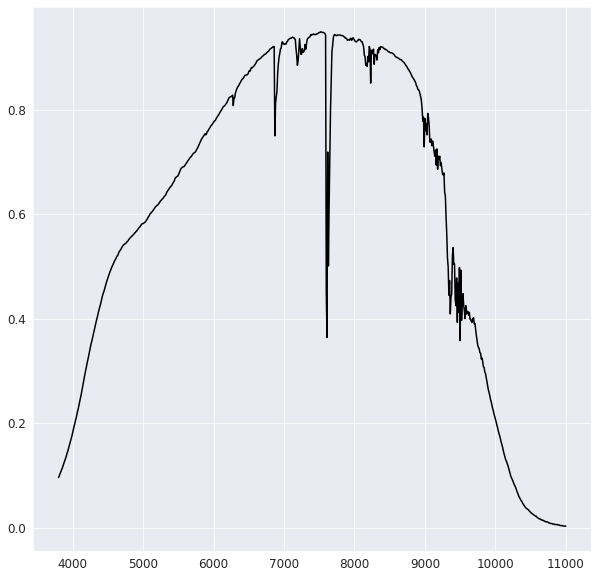

In [85]:
plt.plot(bp.wave, bp.throughput, 'k', label='acs,wfc1,f555w')